In [2]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
from utility import *

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer

#  変分法を用いて量子演算を特定の演算で分解する
- エンタングルメント状態の生成
- エンタングルメント忠実度の計算
- `ParametericQuantumCircuit` クラスを使う

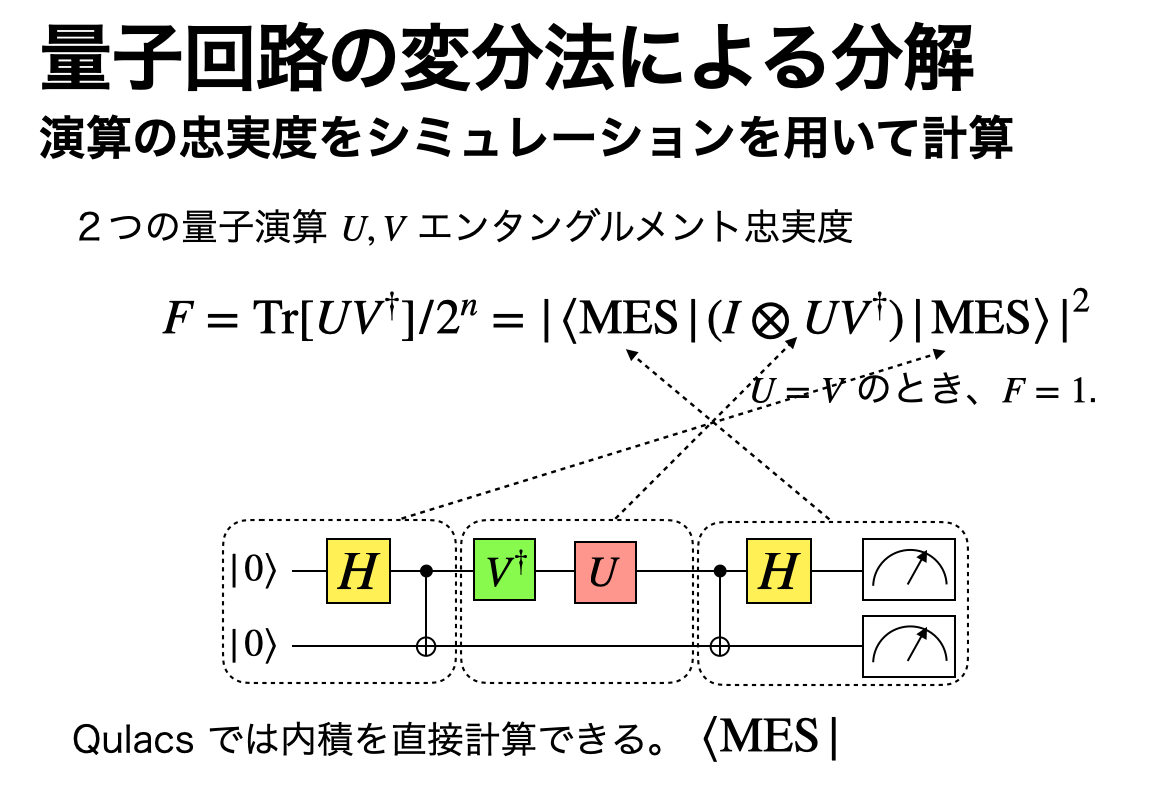

In [8]:
from IPython.display import Image
Image("./fujii_fig01.png",width = 600)

## 最大エンタングル状態の生成

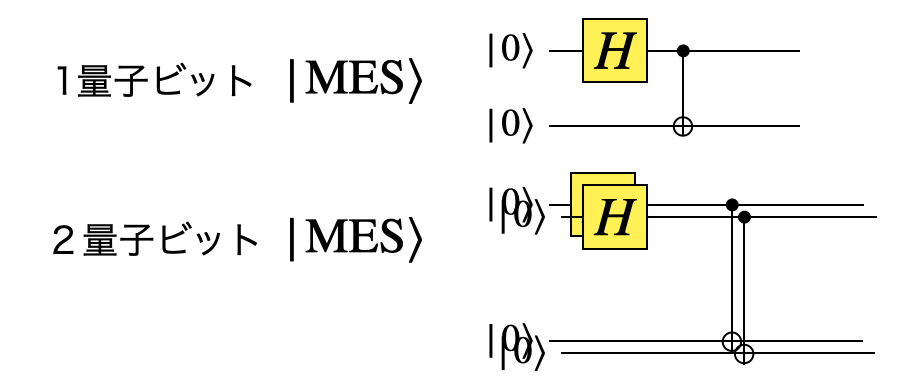

In [9]:
Image("./fujii_fig02.png",width = 600)

In [9]:
nqubits = 2
mes = QuantumState(nqubits)
H(0).update_quantum_state(mes)
CNOT(0,1).update_quantum_state(mes)

0,1基底での確率分布は、

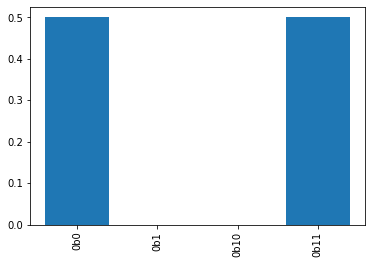

In [10]:
show_distribution(mes)

$\{ |+\rangle , |-\rangle \} $基底での測定は、$H$を作用させてから0,1測定すればいいので

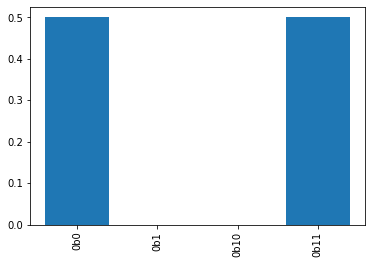

In [11]:
H(0).update_quantum_state(mes)
H(1).update_quantum_state(mes)
show_distribution(mes)

規定を変えても完全相関があることがわかる。2n qubitの最大エンタングル状態を生成する関数を作っておく。

In [12]:
def maximally_entangled_state(nqubits):
    state = QuantumState(2*nqubits)
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        CNOT(i,i+nqubits).update_quantum_state(state)
    return state

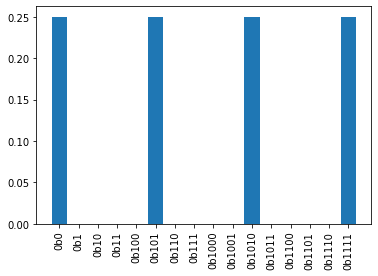

In [13]:
four_qubit_mes = maximally_entangled_state(2)
show_distribution(four_qubit_mes)

## エンタングルメント忠実度を計算する

`RandomUnitary`を用いてターゲットとなるランダムな量子演算を作っておく

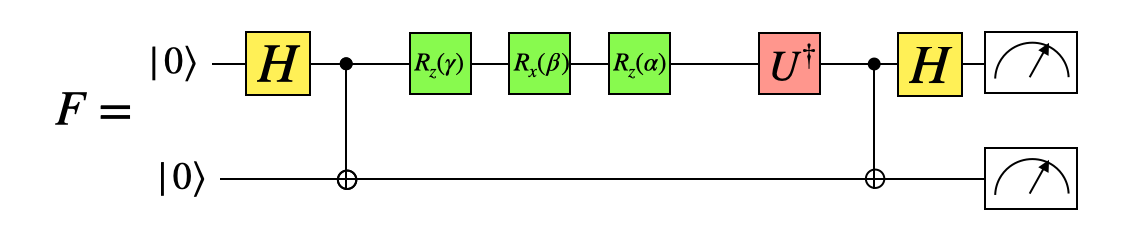

In [10]:
Image("./fujii_fig02b.png",width = 600)

In [19]:
from qulacs.gate import RandomUnitary
target_list = [0]
target_unitary = RandomUnitary(target_list)
print(target_unitary)

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
 (0.110797,0.513608)  (-0.6056,-0.597644)
(0.794854,-0.303543)  (0.308045,-0.42565)



パラメータ付きの量子回路を`ParametricQuantumCircuit`に`add_parametric_RX_gate`で追加する生成する

In [106]:
nqubits = 2 # 2qubitの空間考えているので2qubit分確保しておく

#パラメータ付きの量子回路クラス
ansatz = ParametricQuantumCircuit(nqubits)

#パラメータを回路構成後に変更できる演算
ansatz.add_parametric_RZ_gate(0,0.0)
ansatz.add_parametric_RX_gate(0,0.0)
ansatz.add_parametric_RZ_gate(0,0.0)

#通常の量子演算
ansatz.add_gate(target_unitary)

エンタングルメント忠実度を計算する

In [107]:
mes = maximally_entangled_state(1)
mes_copy = mes.copy()
ansatz.update_quantum_state(mes)

from qulacs.state import inner_product
ent_fidelity = abs(inner_product(mes_copy,mes))**2
print(ent_fidelity)

0.045791443519621014


エンタングルメント忠実度を計算する関数を作っておく

In [108]:
from qulacs.state import inner_product

def entanglement_fidelity(ansatz,nqubits):
    mes = maximally_entangled_state(int(nqubits/2))
    mes_copy = mes.copy()
    ansatz.update_quantum_state(mes)

    ent_fidelity = abs(inner_product(mes_copy,mes))**2
    return ent_fidelity

In [109]:
entanglement_fidelity(ansatz,2)

0.045791443519621014

## 忠実度を最適化することで、演算の分解を見つける

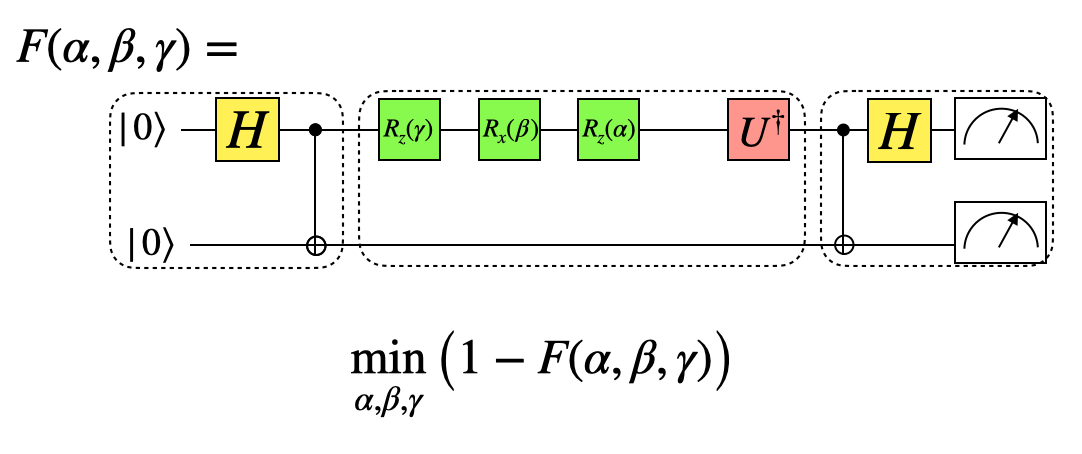

In [11]:
Image("./fujii_fig02c.png",width = 600)

パラメータ付き回路のパラメータを変化させて、ターゲットの量子演算となるパラメータを見つけよう。i番目のパラメータの変更は、`set_parameter(i,new_parameter)`

In [110]:
def cost(parameters):
    num_paras = ansatz.get_parameter_count()

    #パラメータを変更
    for i in range(num_paras):
        ansatz.set_parameter(i,parameters[i])
    
    return 1 - entanglement_fidelity(ansatz,nqubits)

In [111]:
cost([random.random() for i in range(3)])

0.9998970170666427

scipyの最適化関数をつかって、パラメータを変分的に最適化しよう

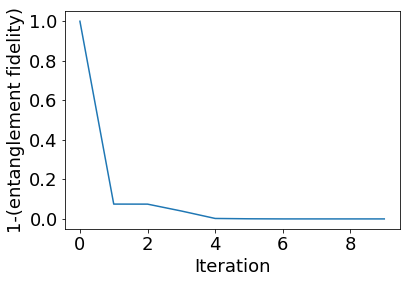

In [112]:
import scipy.optimize

cost_history = []

#パラメータの初期値
init_theta_list = [random.random() for i in range(ansatz.get_parameter_count())]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("1-(entanglement fidelity)")
plt.show()

In [113]:
print("fidelity",opt.fun,"parameters",opt.x)


fidelity 1.6365353516789582e-11 parameters [-0.15233116  2.03516357 -2.15034665]


In [114]:
cost([-0.1523479  , 2.03515578,-2.1503557 ])

1.4137135906366893e-10

できた回路が同じであることを確認しておく（エルミート共役をとるので、パラメータの順序を逆にし、マイナスをつけることを忘れない）
$$
(R_z(\alpha) R_x(\beta) R_z(\gamma))^{\dagger} = R_z(-\gamma) R_x(-\beta) R_z(-\alpha))
$$

In [115]:
nqubits = 1
state0 = QuantumState(nqubits)
state0.set_Haar_random_state()
state1 = state0.copy()

target_unitary.update_quantum_state(state0)

RZ(0,-1.0*opt.x[2]).update_quantum_state(state1)
RX(0,-1.0*opt.x[1]).update_quantum_state(state1)
RZ(0,-1.0*opt.x[0]).update_quantum_state(state1)

abs(inner_product(state0,state1))**2


0.9999999999836513

（全体の位相因子が異なる場合がある。）

## 応用編：CNOT演算を分解する
2量子ビット以上のパウリの回転演算子は`add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, angle)`
で追加できる。`pauli_id_list`はX、Y、Z、をそれぞれ1,2,3として並べたリスト。


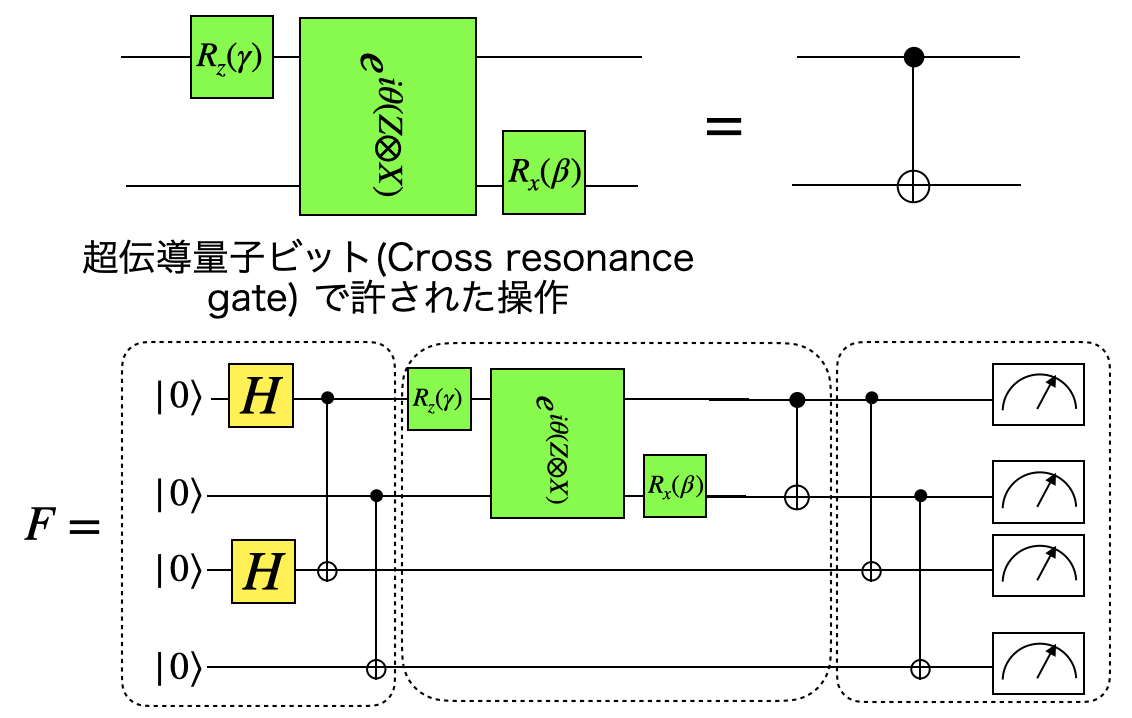

In [12]:
Image("./fujii_fig03.png",width = 600)

In [116]:
nqubits = 4 # 4qubitの空間考えているので4qubit分確保しておく

#パラメータ付きの量子回路クラス
ansatz = ParametricQuantumCircuit(nqubits)

#パラメータを回路構成後に変更できる演算
ansatz.add_parametric_RZ_gate(0,0.0)
ansatz.add_parametric_multi_Pauli_rotation_gate([0,1],[3,1], 0.0)
ansatz.add_parametric_RX_gate(1,0.0)

#ターゲットの量子演算
ansatz.add_gate(CNOT(0,1))

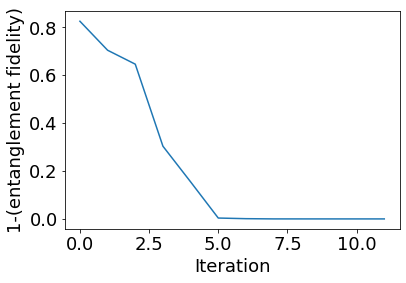

In [119]:

cost_history = []

#パラメータの初期値
init_theta_list = [random.random() for i in range(ansatz.get_parameter_count())]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("1-(entanglement fidelity)")
plt.show()

In [120]:
opt.x

array([-1.57079668,  1.57079738, -1.5707957 ])